# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 50, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 50, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.4929
Epoch 1/200, Iteration 2/12, Loss: 0.9495
Epoch 1/200, Iteration 3/12, Loss: 0.9550
Epoch 1/200, Iteration 4/12, Loss: 0.9073
Epoch 1/200, Iteration 5/12, Loss: 0.5188
Epoch 1/200, Iteration 6/12, Loss: 0.4745
Epoch 1/200, Iteration 7/12, Loss: 0.3704
Epoch 1/200, Iteration 8/12, Loss: 0.2792
Epoch 1/200, Iteration 9/12, Loss: 0.2880
Epoch 1/200, Iteration 10/12, Loss: 0.1704
Epoch 1/200, Iteration 11/12, Loss: 0.1335
Epoch 1/200, Iteration 12/12, Loss: 0.1307
Epoch 1/200, Iteration 13/12, Loss: 0.2648
Train Error: 
 Accuracy: 71.25%, Avg loss: 0.108573, MRE: 0.157957, MAE: 0.029079 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.084023, MRE: 0.148132, MAE: 0.026732 

Epoch 2/200, Iteration 1/12, Loss: 0.1118
Epoch 2/200, Iteration 2/12, Loss: 0.1429
Epoch 2/200, Iteration 3/12, Loss: 0.0767
Epoch 2/200, Iteration 4/12, Loss: 0.0739
Epoch 2/200, Iteration 5/12, Loss: 0.1304
Epoch 2/200, Iteration 6/12, Loss: 0.1009
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 89.88%, Avg loss: 0.014448, MRE: 0.059157, MAE: 0.008984 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.013573, MRE: 0.049481, MAE: 0.009618 

Epoch 14/200, Iteration 1/12, Loss: 0.0095
Epoch 14/200, Iteration 2/12, Loss: 0.0114
Epoch 14/200, Iteration 3/12, Loss: 0.0132
Epoch 14/200, Iteration 4/12, Loss: 0.0252
Epoch 14/200, Iteration 5/12, Loss: 0.0138
Epoch 14/200, Iteration 6/12, Loss: 0.0216
Epoch 14/200, Iteration 7/12, Loss: 0.0102
Epoch 14/200, Iteration 8/12, Loss: 0.0076
Epoch 14/200, Iteration 9/12, Loss: 0.0161
Epoch 14/200, Iteration 10/12, Loss: 0.0049
Epoch 14/200, Iteration 11/12, Loss: 0.0230
Epoch 14/200, Iteration 12/12, Loss: 0.0167
Epoch 14/200, Iteration 13/12, Loss: 0.0134
Train Error: 
 Accuracy: 90.88%, Avg loss: 0.013139, MRE: 0.054875, MAE: 0.008110 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.009874, MRE: 0.043573, MAE: 0.008230 

Epoch 15/200, Iteration 1/12, Loss: 0.0165
Epoch 15/200, Iteration 2/12, Loss: 0.0155
Epoch 15/200, Itera

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.007754, MRE: 0.043219, MAE: 0.006659 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.007786, MRE: 0.034944, MAE: 0.006921 

Epoch 26/200, Iteration 1/12, Loss: 0.0081
Epoch 26/200, Iteration 2/12, Loss: 0.0039
Epoch 26/200, Iteration 3/12, Loss: 0.0044
Epoch 26/200, Iteration 4/12, Loss: 0.0099
Epoch 26/200, Iteration 5/12, Loss: 0.0051
Epoch 26/200, Iteration 6/12, Loss: 0.0050
Epoch 26/200, Iteration 7/12, Loss: 0.0181
Epoch 26/200, Iteration 8/12, Loss: 0.0084
Epoch 26/200, Iteration 9/12, Loss: 0.0162
Epoch 26/200, Iteration 10/12, Loss: 0.0096
Epoch 26/200, Iteration 11/12, Loss: 0.0090
Epoch 26/200, Iteration 12/12, Loss: 0.0064
Epoch 26/200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.008824, MRE: 0.043123, MAE: 0.007095 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.009930, MRE: 0.042188, MAE: 0.007822 

Epoch 27/200, Iteration 1/12, Loss: 0.0069
Epoch 27/200, Iteration 2/12, Loss: 0.0047
Epoch 27/200, Iterat

Train Error: 
 Accuracy: 93.88%, Avg loss: 0.004440, MRE: 0.032953, MAE: 0.004903 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.003681, MRE: 0.030618, MAE: 0.005109 

Epoch 39/200, Iteration 1/12, Loss: 0.0124
Epoch 39/200, Iteration 2/12, Loss: 0.0049
Epoch 39/200, Iteration 3/12, Loss: 0.0032
Epoch 39/200, Iteration 4/12, Loss: 0.0056
Epoch 39/200, Iteration 5/12, Loss: 0.0037
Epoch 39/200, Iteration 6/12, Loss: 0.0043
Epoch 39/200, Iteration 7/12, Loss: 0.0041
Epoch 39/200, Iteration 8/12, Loss: 0.0030
Epoch 39/200, Iteration 9/12, Loss: 0.0074
Epoch 39/200, Iteration 10/12, Loss: 0.0065
Epoch 39/200, Iteration 11/12, Loss: 0.0039
Epoch 39/200, Iteration 12/12, Loss: 0.0029
Epoch 39/200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 91.88%, Avg loss: 0.005500, MRE: 0.035943, MAE: 0.005438 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.003774, MRE: 0.029115, MAE: 0.005344 

Epoch 40/200, Iteration 1/12, Loss: 0.0040
Epoch 40/200, Iteration 2/12, Loss: 0.0036
Epoch 40/200, Itera

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003532, MRE: 0.032891, MAE: 0.004326 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003480, MRE: 0.026796, MAE: 0.004410 

Epoch 52/200, Iteration 1/12, Loss: 0.0042
Epoch 52/200, Iteration 2/12, Loss: 0.0018
Epoch 52/200, Iteration 3/12, Loss: 0.0046
Epoch 52/200, Iteration 4/12, Loss: 0.0046
Epoch 52/200, Iteration 5/12, Loss: 0.0034
Epoch 52/200, Iteration 6/12, Loss: 0.0026
Epoch 52/200, Iteration 7/12, Loss: 0.0037
Epoch 52/200, Iteration 8/12, Loss: 0.0064
Epoch 52/200, Iteration 9/12, Loss: 0.0020
Epoch 52/200, Iteration 10/12, Loss: 0.0013
Epoch 52/200, Iteration 11/12, Loss: 0.0037
Epoch 52/200, Iteration 12/12, Loss: 0.0016
Epoch 52/200, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002790, MRE: 0.030630, MAE: 0.004078 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002364, MRE: 0.023832, MAE: 0.004136 

Epoch 53/200, Iteration 1/12, Loss: 0.0030
Epoch 53/200, Iteration 2/12, Loss: 0.0013
Epoch 53/200, Iterati

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002009, MRE: 0.025484, MAE: 0.003298 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001670, MRE: 0.019794, MAE: 0.003244 

Epoch 64/200, Iteration 1/12, Loss: 0.0013
Epoch 64/200, Iteration 2/12, Loss: 0.0023
Epoch 64/200, Iteration 3/12, Loss: 0.0010
Epoch 64/200, Iteration 4/12, Loss: 0.0033
Epoch 64/200, Iteration 5/12, Loss: 0.0013
Epoch 64/200, Iteration 6/12, Loss: 0.0014
Epoch 64/200, Iteration 7/12, Loss: 0.0027
Epoch 64/200, Iteration 8/12, Loss: 0.0032
Epoch 64/200, Iteration 9/12, Loss: 0.0015
Epoch 64/200, Iteration 10/12, Loss: 0.0013
Epoch 64/200, Iteration 11/12, Loss: 0.0057
Epoch 64/200, Iteration 12/12, Loss: 0.0041
Epoch 64/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002324, MRE: 0.034591, MAE: 0.003542 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001829, MRE: 0.021406, MAE: 0.003647 

Epoch 65/200, Iteration 1/12, Loss: 0.0029
Epoch 65/200, Iteration 2/12, Loss: 0.0017
Epoch 65/200, Iterati

Epoch 76/200, Iteration 11/12, Loss: 0.0012
Epoch 76/200, Iteration 12/12, Loss: 0.0014
Epoch 76/200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001961, MRE: 0.026371, MAE: 0.003925 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001840, MRE: 0.022411, MAE: 0.004020 

Epoch 77/200, Iteration 1/12, Loss: 0.0025
Epoch 77/200, Iteration 2/12, Loss: 0.0018
Epoch 77/200, Iteration 3/12, Loss: 0.0012
Epoch 77/200, Iteration 4/12, Loss: 0.0018
Epoch 77/200, Iteration 5/12, Loss: 0.0020
Epoch 77/200, Iteration 6/12, Loss: 0.0018
Epoch 77/200, Iteration 7/12, Loss: 0.0014
Epoch 77/200, Iteration 8/12, Loss: 0.0021
Epoch 77/200, Iteration 9/12, Loss: 0.0054
Epoch 77/200, Iteration 10/12, Loss: 0.0019
Epoch 77/200, Iteration 11/12, Loss: 0.0026
Epoch 77/200, Iteration 12/12, Loss: 0.0025
Epoch 77/200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.002315, MRE: 0.027181, MAE: 0.003639 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001848, MRE: 

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001674, MRE: 0.023870, MAE: 0.003194 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001562, MRE: 0.021743, MAE: 0.003313 

Epoch 89/200, Iteration 1/12, Loss: 0.0021
Epoch 89/200, Iteration 2/12, Loss: 0.0015
Epoch 89/200, Iteration 3/12, Loss: 0.0011
Epoch 89/200, Iteration 4/12, Loss: 0.0052
Epoch 89/200, Iteration 5/12, Loss: 0.0006
Epoch 89/200, Iteration 6/12, Loss: 0.0014
Epoch 89/200, Iteration 7/12, Loss: 0.0034
Epoch 89/200, Iteration 8/12, Loss: 0.0010
Epoch 89/200, Iteration 9/12, Loss: 0.0026
Epoch 89/200, Iteration 10/12, Loss: 0.0030
Epoch 89/200, Iteration 11/12, Loss: 0.0047
Epoch 89/200, Iteration 12/12, Loss: 0.0009
Epoch 89/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.002802, MRE: 0.028461, MAE: 0.004191 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002553, MRE: 0.023739, MAE: 0.003969 

Epoch 90/200, Iteration 1/12, Loss: 0.0039
Epoch 90/200, Iteration 2/12, Loss: 0.0020
Epoch 90/200, Itera

Epoch 100/200, Iteration 3/12, Loss: 0.0016
Epoch 100/200, Iteration 4/12, Loss: 0.0012
Epoch 100/200, Iteration 5/12, Loss: 0.0015
Epoch 100/200, Iteration 6/12, Loss: 0.0016
Epoch 100/200, Iteration 7/12, Loss: 0.0014
Epoch 100/200, Iteration 8/12, Loss: 0.0025
Epoch 100/200, Iteration 9/12, Loss: 0.0013
Epoch 100/200, Iteration 10/12, Loss: 0.0024
Epoch 100/200, Iteration 11/12, Loss: 0.0011
Epoch 100/200, Iteration 12/12, Loss: 0.0009
Epoch 100/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.001961, MRE: 0.027004, MAE: 0.003331 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.001645, MRE: 0.018978, MAE: 0.003361 

Epoch 101/200, Iteration 1/12, Loss: 0.0018
Epoch 101/200, Iteration 2/12, Loss: 0.0013
Epoch 101/200, Iteration 3/12, Loss: 0.0011
Epoch 101/200, Iteration 4/12, Loss: 0.0010
Epoch 101/200, Iteration 5/12, Loss: 0.0010
Epoch 101/200, Iteration 6/12, Loss: 0.0013
Epoch 101/200, Iteration 7/12, Loss: 0.0014
Epoch 101/200, Iteration 8/12, Loss: 0

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001030, MRE: 0.019244, MAE: 0.002609 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000898, MRE: 0.013692, MAE: 0.002499 

Epoch 113/200, Iteration 1/12, Loss: 0.0021
Epoch 113/200, Iteration 2/12, Loss: 0.0008
Epoch 113/200, Iteration 3/12, Loss: 0.0013
Epoch 113/200, Iteration 4/12, Loss: 0.0012
Epoch 113/200, Iteration 5/12, Loss: 0.0020
Epoch 113/200, Iteration 6/12, Loss: 0.0007
Epoch 113/200, Iteration 7/12, Loss: 0.0007
Epoch 113/200, Iteration 8/12, Loss: 0.0008
Epoch 113/200, Iteration 9/12, Loss: 0.0007
Epoch 113/200, Iteration 10/12, Loss: 0.0014
Epoch 113/200, Iteration 11/12, Loss: 0.0007
Epoch 113/200, Iteration 12/12, Loss: 0.0015
Epoch 113/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.001130, MRE: 0.019180, MAE: 0.002571 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001048, MRE: 0.015131, MAE: 0.002702 

Epoch 114/200, Iteration 1/12, Loss: 0.0015
Epoch 114/200, Iteration 2/12, Loss: 0.0008
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.001053, MRE: 0.019377, MAE: 0.002675 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001004, MRE: 0.013951, MAE: 0.002808 

Epoch 125/200, Iteration 1/12, Loss: 0.0007
Epoch 125/200, Iteration 2/12, Loss: 0.0012
Epoch 125/200, Iteration 3/12, Loss: 0.0013
Epoch 125/200, Iteration 4/12, Loss: 0.0015
Epoch 125/200, Iteration 5/12, Loss: 0.0009
Epoch 125/200, Iteration 6/12, Loss: 0.0007
Epoch 125/200, Iteration 7/12, Loss: 0.0022
Epoch 125/200, Iteration 8/12, Loss: 0.0006
Epoch 125/200, Iteration 9/12, Loss: 0.0010
Epoch 125/200, Iteration 10/12, Loss: 0.0010
Epoch 125/200, Iteration 11/12, Loss: 0.0013
Epoch 125/200, Iteration 12/12, Loss: 0.0007
Epoch 125/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000868, MRE: 0.018606, MAE: 0.002308 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000709, MRE: 0.012613, MAE: 0.002407 

Epoch 126/200, Iteration 1/12, Loss: 0.0014
Epoch 126/200, Iteration 2/12, Loss: 0.0008
Epoch

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000696, MRE: 0.012930, MAE: 0.002322 

Epoch 137/200, Iteration 1/12, Loss: 0.0005
Epoch 137/200, Iteration 2/12, Loss: 0.0006
Epoch 137/200, Iteration 3/12, Loss: 0.0007
Epoch 137/200, Iteration 4/12, Loss: 0.0009
Epoch 137/200, Iteration 5/12, Loss: 0.0012
Epoch 137/200, Iteration 6/12, Loss: 0.0006
Epoch 137/200, Iteration 7/12, Loss: 0.0012
Epoch 137/200, Iteration 8/12, Loss: 0.0014
Epoch 137/200, Iteration 9/12, Loss: 0.0012
Epoch 137/200, Iteration 10/12, Loss: 0.0011
Epoch 137/200, Iteration 11/12, Loss: 0.0005
Epoch 137/200, Iteration 12/12, Loss: 0.0005
Epoch 137/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000689, MRE: 0.017378, MAE: 0.002183 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000677, MRE: 0.012024, MAE: 0.002328 

Epoch 138/200, Iteration 1/12, Loss: 0.0008
Epoch 138/200, Iteration 2/12, Loss: 0.0010
Epoch 138/200, Iteration 3/12, Loss: 0.0006
Epoch 138/200, Iteration 4/12, Loss: 0.0007
E

Epoch 148/200, Iteration 10/12, Loss: 0.0019
Epoch 148/200, Iteration 11/12, Loss: 0.0010
Epoch 148/200, Iteration 12/12, Loss: 0.0010
Epoch 148/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000941, MRE: 0.022430, MAE: 0.002690 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000642, MRE: 0.013720, MAE: 0.002476 

Epoch 149/200, Iteration 1/12, Loss: 0.0010
Epoch 149/200, Iteration 2/12, Loss: 0.0007
Epoch 149/200, Iteration 3/12, Loss: 0.0007
Epoch 149/200, Iteration 4/12, Loss: 0.0006
Epoch 149/200, Iteration 5/12, Loss: 0.0006
Epoch 149/200, Iteration 6/12, Loss: 0.0006
Epoch 149/200, Iteration 7/12, Loss: 0.0013
Epoch 149/200, Iteration 8/12, Loss: 0.0009
Epoch 149/200, Iteration 9/12, Loss: 0.0003
Epoch 149/200, Iteration 10/12, Loss: 0.0015
Epoch 149/200, Iteration 11/12, Loss: 0.0007
Epoch 149/200, Iteration 12/12, Loss: 0.0010
Epoch 149/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000682, MRE: 0.016465, MAE: 0.0021

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000553, MRE: 0.014645, MAE: 0.001837 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000521, MRE: 0.010387, MAE: 0.001957 

Epoch 161/200, Iteration 1/12, Loss: 0.0012
Epoch 161/200, Iteration 2/12, Loss: 0.0006
Epoch 161/200, Iteration 3/12, Loss: 0.0007
Epoch 161/200, Iteration 4/12, Loss: 0.0007
Epoch 161/200, Iteration 5/12, Loss: 0.0007
Epoch 161/200, Iteration 6/12, Loss: 0.0003
Epoch 161/200, Iteration 7/12, Loss: 0.0005
Epoch 161/200, Iteration 8/12, Loss: 0.0006
Epoch 161/200, Iteration 9/12, Loss: 0.0004
Epoch 161/200, Iteration 10/12, Loss: 0.0006
Epoch 161/200, Iteration 11/12, Loss: 0.0004
Epoch 161/200, Iteration 12/12, Loss: 0.0003
Epoch 161/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.000549, MRE: 0.014962, MAE: 0.001828 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000518, MRE: 0.010463, MAE: 0.001966 

Epoch 162/200, Iteration 1/12, Loss: 0.0005
Epoch 162/200, Iteration 2/12, Loss: 0.0009
Epoch

Epoch 173/200, Iteration 2/12, Loss: 0.0007
Epoch 173/200, Iteration 3/12, Loss: 0.0003
Epoch 173/200, Iteration 4/12, Loss: 0.0003
Epoch 173/200, Iteration 5/12, Loss: 0.0008
Epoch 173/200, Iteration 6/12, Loss: 0.0004
Epoch 173/200, Iteration 7/12, Loss: 0.0004
Epoch 173/200, Iteration 8/12, Loss: 0.0004
Epoch 173/200, Iteration 9/12, Loss: 0.0003
Epoch 173/200, Iteration 10/12, Loss: 0.0006
Epoch 173/200, Iteration 11/12, Loss: 0.0005
Epoch 173/200, Iteration 12/12, Loss: 0.0006
Epoch 173/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.000537, MRE: 0.015273, MAE: 0.001798 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000506, MRE: 0.010493, MAE: 0.001957 

Epoch 174/200, Iteration 1/12, Loss: 0.0014
Epoch 174/200, Iteration 2/12, Loss: 0.0008
Epoch 174/200, Iteration 3/12, Loss: 0.0003
Epoch 174/200, Iteration 4/12, Loss: 0.0003
Epoch 174/200, Iteration 5/12, Loss: 0.0003
Epoch 174/200, Iteration 6/12, Loss: 0.0005
Epoch 174/200, Iteration 7/12, Loss: 0

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000533, MRE: 0.014726, MAE: 0.001803 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000518, MRE: 0.010323, MAE: 0.001940 

Epoch 186/200, Iteration 1/12, Loss: 0.0006
Epoch 186/200, Iteration 2/12, Loss: 0.0003
Epoch 186/200, Iteration 3/12, Loss: 0.0005
Epoch 186/200, Iteration 4/12, Loss: 0.0003
Epoch 186/200, Iteration 5/12, Loss: 0.0004
Epoch 186/200, Iteration 6/12, Loss: 0.0009
Epoch 186/200, Iteration 7/12, Loss: 0.0008
Epoch 186/200, Iteration 8/12, Loss: 0.0004
Epoch 186/200, Iteration 9/12, Loss: 0.0004
Epoch 186/200, Iteration 10/12, Loss: 0.0009
Epoch 186/200, Iteration 11/12, Loss: 0.0005
Epoch 186/200, Iteration 12/12, Loss: 0.0005
Epoch 186/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000535, MRE: 0.014937, MAE: 0.001807 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000511, MRE: 0.010463, MAE: 0.001969 

Epoch 187/200, Iteration 1/12, Loss: 0.0009
Epoch 187/200, Iteration 2/12, Loss: 0.0006
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000539, MRE: 0.014624, MAE: 0.001794 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000501, MRE: 0.010239, MAE: 0.001925 

Epoch 198/200, Iteration 1/12, Loss: 0.0009
Epoch 198/200, Iteration 2/12, Loss: 0.0003
Epoch 198/200, Iteration 3/12, Loss: 0.0009
Epoch 198/200, Iteration 4/12, Loss: 0.0004
Epoch 198/200, Iteration 5/12, Loss: 0.0012
Epoch 198/200, Iteration 6/12, Loss: 0.0003
Epoch 198/200, Iteration 7/12, Loss: 0.0005
Epoch 198/200, Iteration 8/12, Loss: 0.0004
Epoch 198/200, Iteration 9/12, Loss: 0.0003
Epoch 198/200, Iteration 10/12, Loss: 0.0004
Epoch 198/200, Iteration 11/12, Loss: 0.0004
Epoch 198/200, Iteration 12/12, Loss: 0.0005
Epoch 198/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000523, MRE: 0.014675, MAE: 0.001787 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000500, MRE: 0.010270, MAE: 0.001926 

Epoch 199/200, Iteration 1/12, Loss: 0.0005
Epoch 199/200, Iteration 2/12, Loss: 0.0006
Epoch 

#### Plots loss vs Epoch

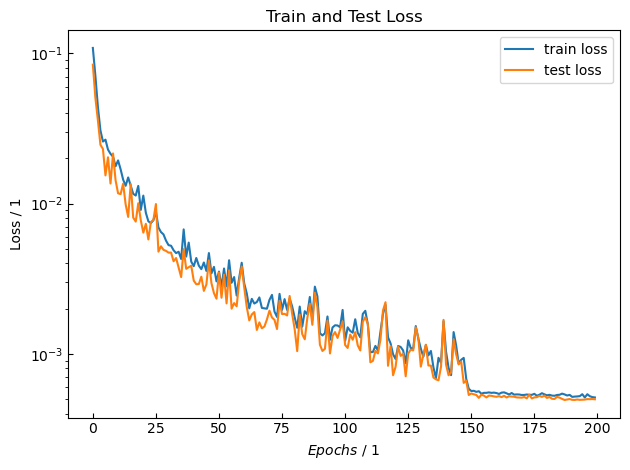

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998030968931527 , R^2(NH3) = 0.9991443506322982
Test Dataset: R^2(H2) = 0.9997139371713738 , R^2(NH3) = 0.999268548365021
Max Error Training: |x_H2 - x_H2,pred| = 0.020384787042190933 , |x_NH3 - x_NH3,pred| = 0.01953892476111957
Max Error Test: |x_H2 - x_H2,pred| = 0.012470603245048228 , |x_NH3 - x_NH3,pred| = 0.016866386575192432


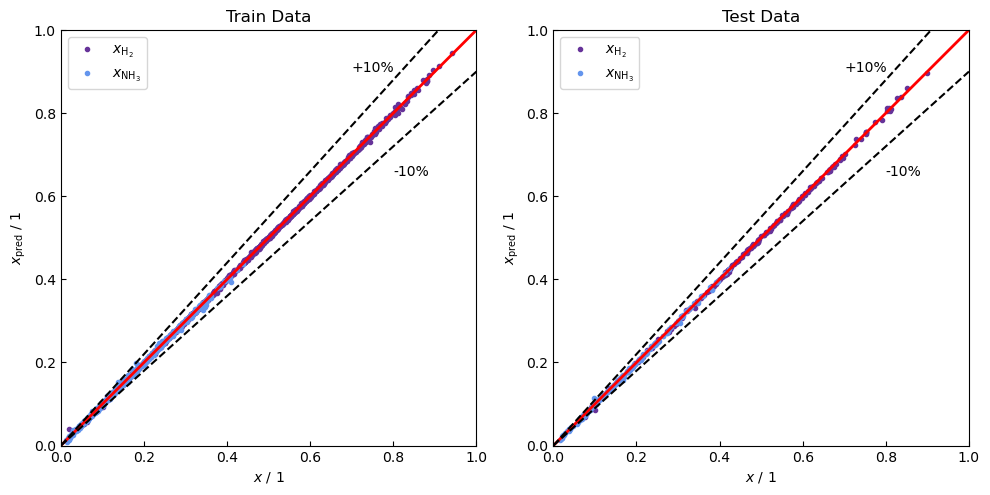

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

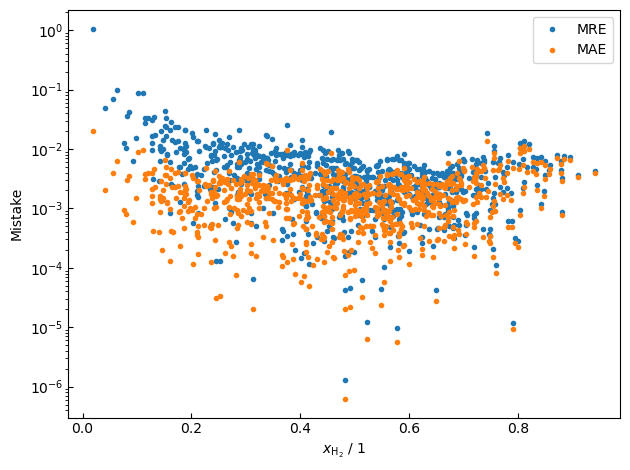

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

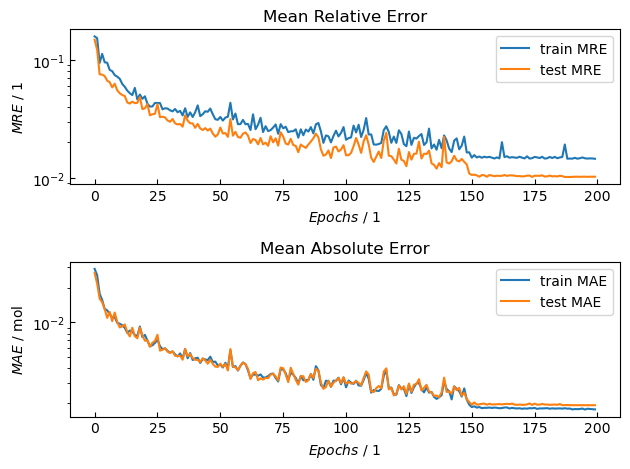

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

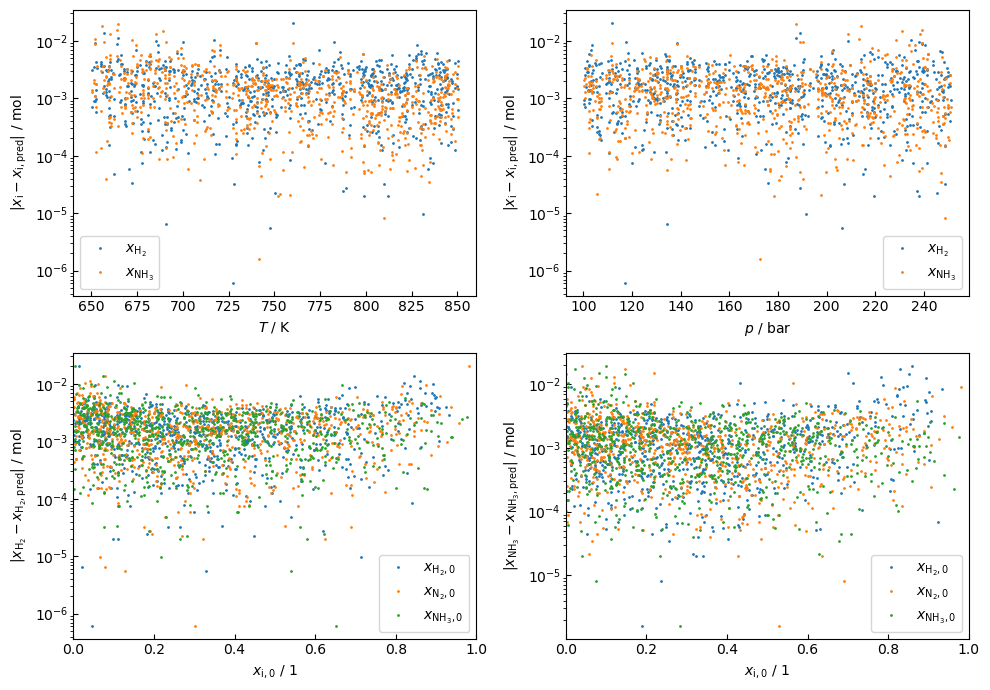

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

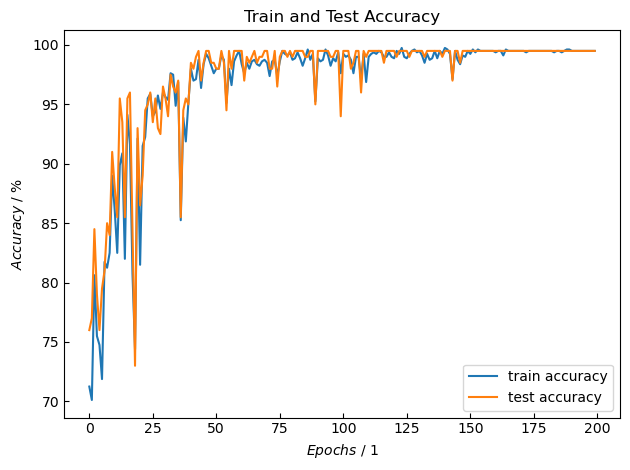

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-0.4671, -0.2839, -1.1062, -1.3442,  2.4594],
        [-1.2655, -0.7443,  0.0043, -0.1475,  0.1466],
        [-0.3163,  1.6484, -1.2782,  1.1253,  0.1043],
        [ 0.3304, -1.2976,  0.6917, -0.9320,  0.2738],
        [-0.6169, -0.2025,  1.1742,  0.0534, -1.2069],
        [-1.5485,  0.2679,  2.2703, -1.2167, -0.9844],
        [ 1.3420,  1.0437, -0.7565,  0.5588,  0.1712],
        [ 1.0014,  1.1074,  0.5264,  0.4693, -0.9962],
        [-0.9528, -1.3571, -0.2601, -0.7591,  1.0312],
        [ 0.9566, -0.1432,  1.8299, -0.9175, -0.8581],
        [-1.6128, -0.1040,  1.0120, -0.1615, -0.8281],
        [-1.2668,  0.1841, -0.1153, -0.5726,  0.6984],
        [ 0.2353, -0.2784, -0.5924,  0.9041, -0.3426],
        [ 0.6416,  0.0905, -0.4138,  0.2182,  0.1831],
        [-0.3941,  0.9132,  0.4261, -0.4673,  0.0594],
        [-1.0200, -1.4790, -0.0270, -0.7800,  0.8238],
        [-0.0730, -1.4348,  1.8731, -1.0964, -0.7176],
        [ 1.4179,  1.6501,  1.4858, -1.1919, -0.2400],
        [ 

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.0858, -0.3484,  0.3178, -0.2543,  0.0497],
         [-0.4380,  0.2020, -0.5191,  0.5117, -0.3789],
         [ 0.1381, -0.2786, -0.0420,  0.1184,  0.2860],
         [-0.5565,  0.1357, -0.1918,  0.2142,  0.3696],
         [-0.3700,  0.1200,  0.4032, -0.3197, -0.1391],
         [-0.5127,  0.1576,  0.0759, -0.1508,  0.4305],
         [ 0.0809, -0.0336,  0.0051,  0.2434,  0.3003],
         [ 0.0292, -0.2758, -0.3124, -0.1291, -0.4078],
         [ 0.2126, -0.2073,  0.5073, -0.4764,  0.2671],
         [-0.1387,  0.3677, -0.2102, -0.2005,  0.0168],
         [ 0.0809, -0.2961,  0.4073,  0.0701,  0.3162],
         [ 0.0977,  0.0068,  0.1709,  0.1367,  0.1557],
         [-0.4829,  0.1399,  0.7132,  0.0568, -0.1138],
         [-0.4313,  0.3399,  0.1867, -0.1998,  0.3432],
         [-0.3981,  0.2730, -0.1673, -0.2672,  0.1110],
         [ 0.3066,  0.1511, -0.2542, -0.0467,  0.2563],
         [-0.7408,  0.1884, -0.7042,  0.1024, -0.7527],
         [ 0.0077,  0.185

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2057, 0.8723, 0.0017, 0.7224, 0.7361],
        [0.6408, 0.0902, 0.0207, 0.3834, 0.4095]])
tensor([[-0.1205, -0.0387],
        [ 0.1534, -0.4091]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.2379e+00,  8.2670e-02,  1.6796e+00, -9.8962e-01, -6.3687e-01],
        [-7.3827e-01,  1.5948e+00, -3.1810e-01,  1.6572e+00, -1.3816e+00],
        [ 8.0753e-01,  8.2430e-01,  4.5165e-01, -9.2479e-01,  5.0196e-01],
        [ 1.1035e+00,  3.8386e-01,  2.5076e-01, -1.2986e+00,  1.0812e+00],
        [-6.6981e-01,  1.0401e+00,  2.1113e+00, -1.1116e+00, -9.3579e-01],
        [-4.1436e-01,  1.0392e+00,  2.8921e-01, -2.7491e-01, -2.8432e-03],
        [-1.5203e+00,  1.7218e+00,  6.4117e-01, -9.9112e-01,  3.8376e-01],
        [ 7.6843e-01,  1.1924e+00, -1.3593e-01, -4.7092e-01,  6.1471e-01],
        [-6.6734e-01, -1.7169e+00, -1.0734e+00, -2.7688e-01,  1.3364e+00],
        [ 1.4124e+00,  5.6166e-01,  2.2479e+00, -1.0994e+00, -1.0824e+00],
        [-3.5059e-01, -3.5045e-02, -6.4317e-03, -3.6549e-01,  3.7987e-01],
        [-1.2688e+00, -4.6072e-01,  3.3478e-01, -4.5670e-01,  1.3823e-01],
        [-1.9339e-01, -1.0697e+00, -1.2763e+00, -1.2917e+00,  2.5728e+00],
        [-8.3855e-01,  1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

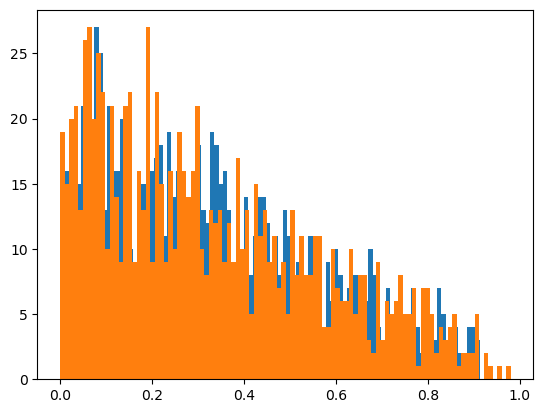

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_022.pth')
# np.savez('data/models/params_005_022.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)